### Import necessary libraries

In [4]:
# Setup
import preprocess
import interpret
import annotate
import musics
import matplotlib.pyplot as plt
import cv2

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Intialize global variables

In [5]:
# image file to process
input_file = 'sheet_music/Mary_Had_A_Little_Lamb.png'
# TODO accept pdfs? or at least throw error if not an image

# TODO bryant format this however you want -- just initialize file and notes data structures so we can pass them as params in the diff funcs
notes = dict()  # dictionary of {int noteID num : Note class instance}

key_signtaure = "C"  

### Preprocess image
Filter image, find staff lines and notes, gather useful data from image

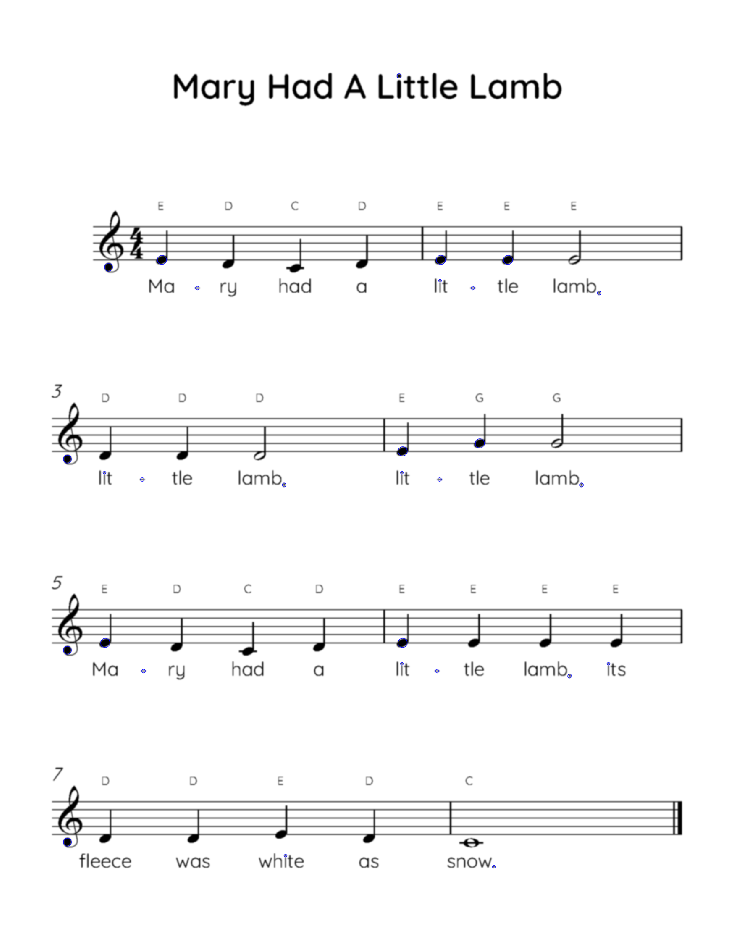

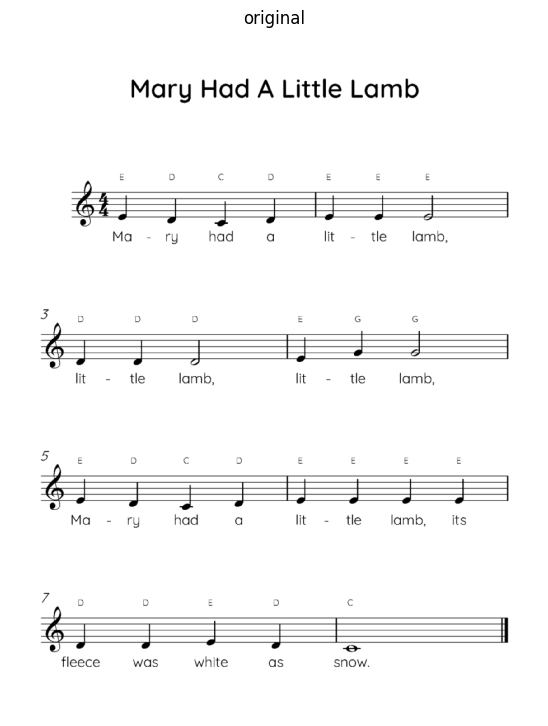

In [9]:
# reads input file as a numpy image
# returns grayscale version of image, and guassian blurred image
img, smoothed = preprocess.filter_img(input_file)

# TODO bryant identify staff lines
# TODO bryant take staff lines out of image

# Finds blobs of notes in image
blobs = preprocess.find_blobs(smoothed, display=True)

# crop all blobs to images of individual notes
# return list of cropped images
cropped_notes = preprocess.get_cropped_notes(blobs, img, save=False)

### Interpret
Interpret gathered staff and note data, turning positional pixel data into musical notation

In [ ]:
# TODO call interpret funcs

### Annotate
Annotate the original image file with interpreted note letters, giving the user back an annotated file and MIDI audio file to practice with

In [ ]:
# TODO call annotate funcs